# Data Pre-Processing

#### Import Packages and CSV

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import warnings
warnings.filterwarnings("ignore")
pd.pandas.set_option("display.max_columns", None)

In [2]:
df = pd.read_csv('../data/train.csv')
df.head()

,Customer Id,Artist Name,Artist Reputation,Height,Width,Weight,Material,Price Of Sculpture,Base Shipping Price,International,Express Shipment,Installation Included,Transport,Fragile,Customer Information,Remote Location,Scheduled Date,Delivery Date,Customer Location,Cost
0,fffe3900350033003300,Billy Jenkins,0.26,17.0,6.0,4128.0,Brass,13.91,16.27,Yes,Yes,No,Airways,No,Working Class,No,06/07/15,06/03/15,"New Michelle, OH 50777",-283.29
1,fffe3800330031003900,Jean Bryant,0.28,3.0,3.0,61.0,Brass,6.83,15.00,No,No,No,Roadways,No,Working Class,No,03/06/17,03/05/17,"New Michaelport, WY 12072",-159.96
2,fffe3600370035003100,Laura Miller,0.07,8.0,5.0,237.0,Clay,4.96,21.18,No,No,No,Roadways,Yes,Working Class,Yes,03/09/15,03/08/15,"Bowmanshire, WA 19241",-154.29
3,fffe350031003300,Robert Chaires,0.12,9.0,NaN,NaN,Aluminium,5.81,16.31,No,No,No,NaN,No,Wealthy,Yes,05/24/15,05/20/15,"East Robyn, KY 86375",-161.16
4,fffe3900320038003400,Rosalyn Krol,0.15,17.0,6.0,324.0,Aluminium,3.18,11.94,Yes,Yes,Yes,Airways,No,Working Class,No,12/18/16,12/14/16,"Aprilside, PA 52793",-159.23


## Data Cleaning

#### Check Null Values

In [14]:
df.isnull().mean()[df.isnull().mean() > 0.0]

Artist Reputation    0.115385
Height               0.057692
Width                0.089846
Weight               0.090308
Material             0.117538
Transport            0.214154
Remote Location      0.118615
dtype: float64

In [19]:
def print_missing_value_stats(df, threshold=0, sort=True):
    """Calculates and prints missing value percentages for columns above a given threshold."""

    missing_value_counts = df.isnull().mean()  

    columns_to_print = missing_value_counts[missing_value_counts > threshold]
    
    if sort:
        columns_to_print = columns_to_print.sort_values(ascending=False)

    if columns_to_print.empty:
        print("No columns have missing values above the specified threshold.")
    else:
        print(f"\nColumns with Missing Values (Threshold: {threshold * 100:.1f}%):\n")
        print("--------------------------------------------------")
        for col, pct_missing in columns_to_print.items():
            print(f"{col:<30}  {pct_missing*100:.2f}%") 

print_missing_value_stats(df) # Print all columns with missing values


Columns with Missing Values (Threshold: 0.0%):

--------------------------------------------------
Transport                       21.42%
Remote Location                 11.86%
Material                        11.75%
Artist Reputation               11.54%
Weight                          9.03%
Width                           8.98%
Height                          5.77%


In [20]:
print_missing_value_stats(df,threshold=0.1) # Print only columns with at least 10% missing values


Columns with Missing Values (Threshold: 10.0%):

--------------------------------------------------
Transport                       21.42%
Remote Location                 11.86%
Material                        11.75%
Artist Reputation               11.54%


#### Checking duplicated values


In [21]:
df.duplicated().sum()

0

 * There are no duplicates values in the data

#### Seperating Features


In [26]:
def classify_features(df, target_feature):
    """Classifies features in a DataFrame into numerical and non-numerical (categorical)."""

    all_features = df.columns.drop(target_feature)

    numeric_features = df[all_features].select_dtypes(include=np.number).columns.tolist()
    non_numeric_features = df[all_features].select_dtypes(exclude=np.number).columns.tolist()

    print(f"\nNumerical features ({len(numeric_features)}):")
    print(numeric_features)

    print(f"\nNon-numeric (categorical) features ({len(non_numeric_features)}):")
    print(non_numeric_features)

    return numeric_features, non_numeric_features

target_feature = 'Cost'
numeric_features, non_numeric_features = classify_features(df, target_feature)



Numerical features (6):
['Artist Reputation', 'Height', 'Width', 'Weight', 'Price Of Sculpture', 'Base Shipping Price']

Non-numeric (categorical) features (13):
['Customer Id', 'Artist Name', 'Material', 'International', 'Express Shipment', 'Installation Included', 'Transport', 'Fragile', 'Customer Information', 'Remote Location', 'Scheduled Date', 'Delivery Date', 'Customer Location']


Imputing null values with median to check the multicollinearity

In [35]:
df1 = df.copy()
df1[numeric_features] = df1[numeric_features].fillna(df1[numeric_features].median())


### Multicollinearity Check
#### Variance Inflation Factor (VIF)

* Multicollinearity occurs when there are two or more independent variables in a multiple regression model, which have a high correlation among themselves. When some features are highly correlated.
* Multicollinearity can be detected using various techniques, one such technique being the Variance Inflation Factor(VIF).

In [39]:
import statsmodels.api as sm

In [40]:
for i in range(0, len(numeric_features)):
    x = df1.loc[:, df1.columns == numeric_features[i]]
    y = df1.Cost
    model = sm.OLS(x,y)
    results = model.fit()
    rsq = results.rsquared
    vif = round(1 / (1 - rsq), 2)
    print(
        "Variance Inflation Factor of {} column is {} \n".format(
            numeric_features[i], vif)
        )


Variance Inflation Factor of Artist Reputation column is 1.01 

Variance Inflation Factor of Height column is 1.01 

Variance Inflation Factor of Width column is 1.02 

Variance Inflation Factor of Weight column is 1.2 

Variance Inflation Factor of Price Of Sculpture column is 1.3 

Variance Inflation Factor of Base Shipping Price column is 1.01 



In [41]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [42]:
def calculate_vif(df, features):
    """Calculates and prints Variance Inflation Factors (VIFs) for given features."""
    
    X = sm.add_constant(df[features])  # Add a constant term for the intercept
    vif_data = pd.DataFrame()
    vif_data["feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    
    # Exclude the constant term from VIF output
    vif_data = vif_data[vif_data["feature"] != "const"]
    
    print("\nVariance Inflation Factors (VIFs):\n")
    print(vif_data)

calculate_vif(df1, numeric_features)



Variance Inflation Factors (VIFs):

               feature       VIF
1    Artist Reputation  1.005484
2               Height  2.066713
3                Width  2.132813
4               Weight  4.284500
5   Price Of Sculpture  4.234846
6  Base Shipping Price  1.150158


### Note:  All the columns has VIF around 1, so there is not severe multicollinearity

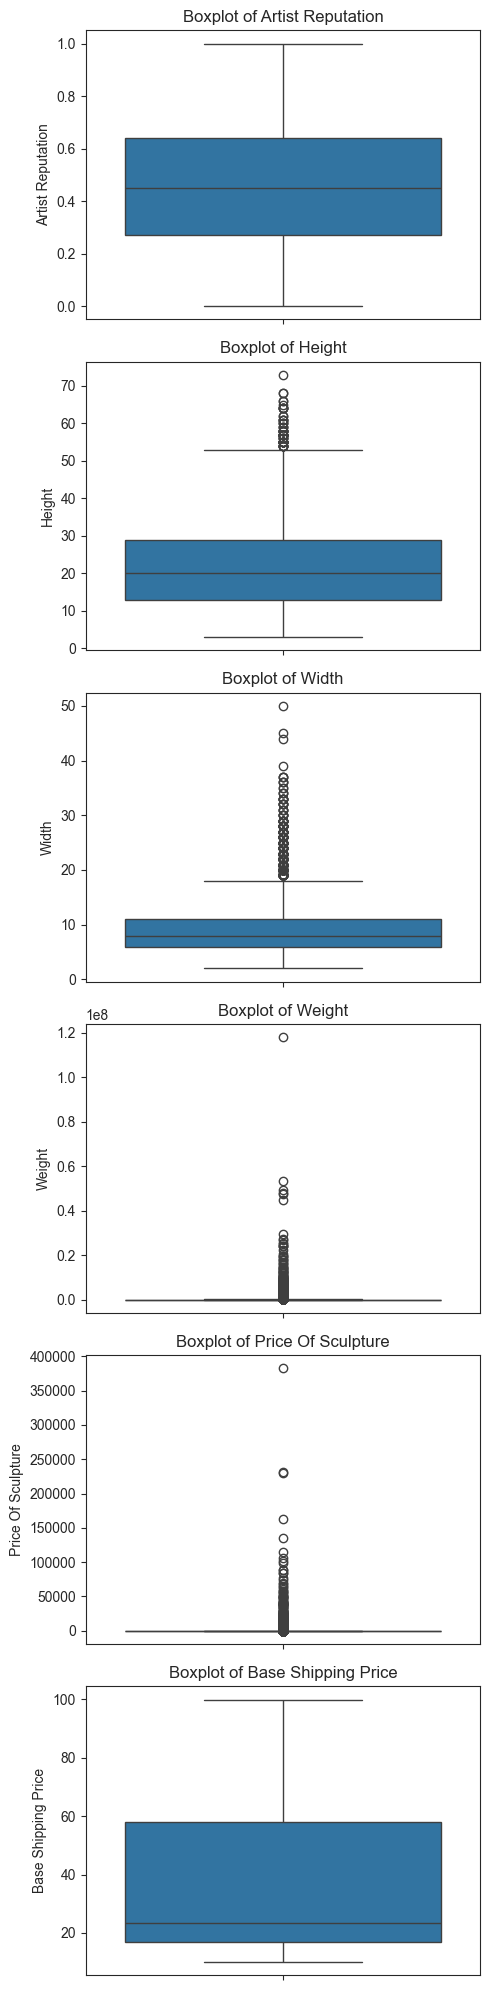

In [50]:
sns.set_style('ticks')
fig, axes = plt.subplots(nrows=len(numeric_features), figsize=(5, 20)) 

for i, feature in enumerate(numeric_features):
    sns.boxplot(data=df1[feature], ax=axes[i])
    axes[i].set_title(f'Boxplot of {feature}')

plt.tight_layout()  
plt.show()


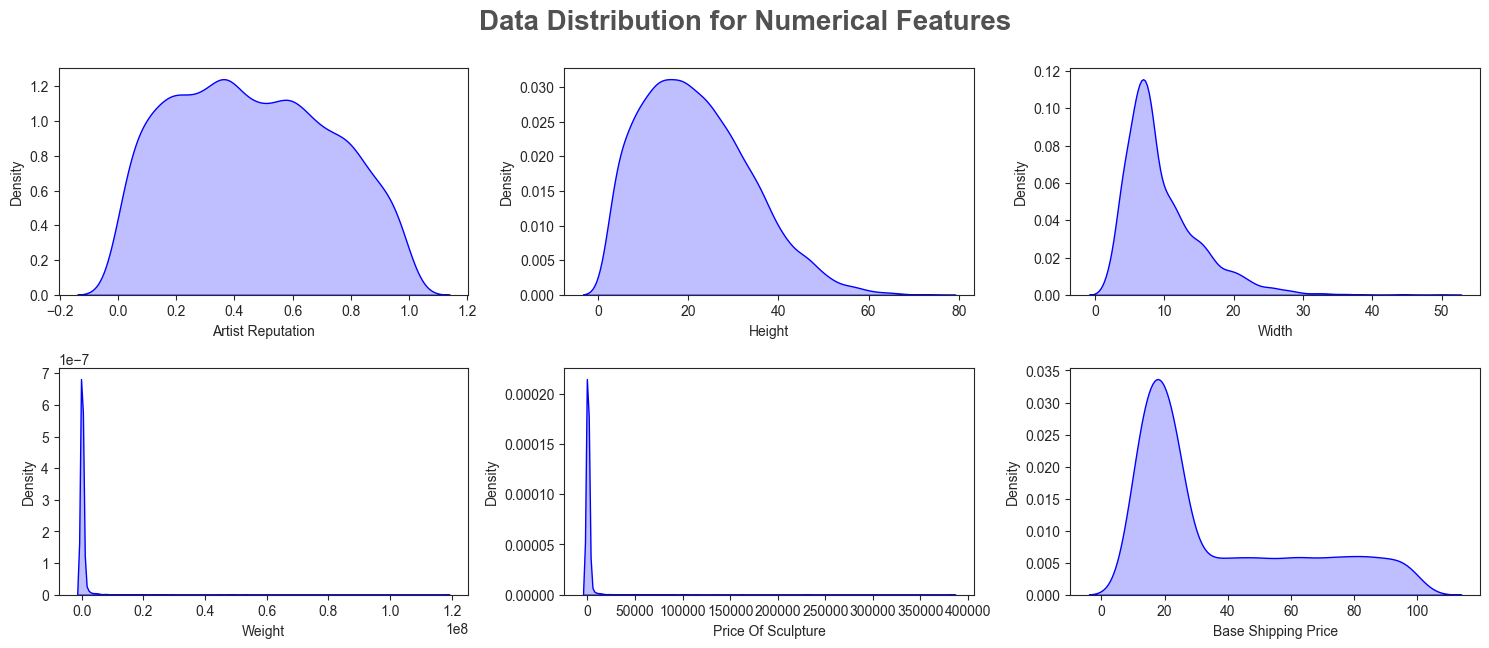

In [51]:
plt.figure(figsize=(15, 15))
plt.suptitle('Data Distribution for Numerical Features', fontsize=20, fontweight='bold', alpha=0.8, y=1.)

for i in range(0, len(numeric_features)):
    plt.subplot(5, 3, i+1)
    sns.kdeplot(x=df[numeric_features[i]],shade=True, color='b')
    plt.xlabel(numeric_features[i])
    plt.tight_layout()

<Figure size 640x480 with 0 Axes>

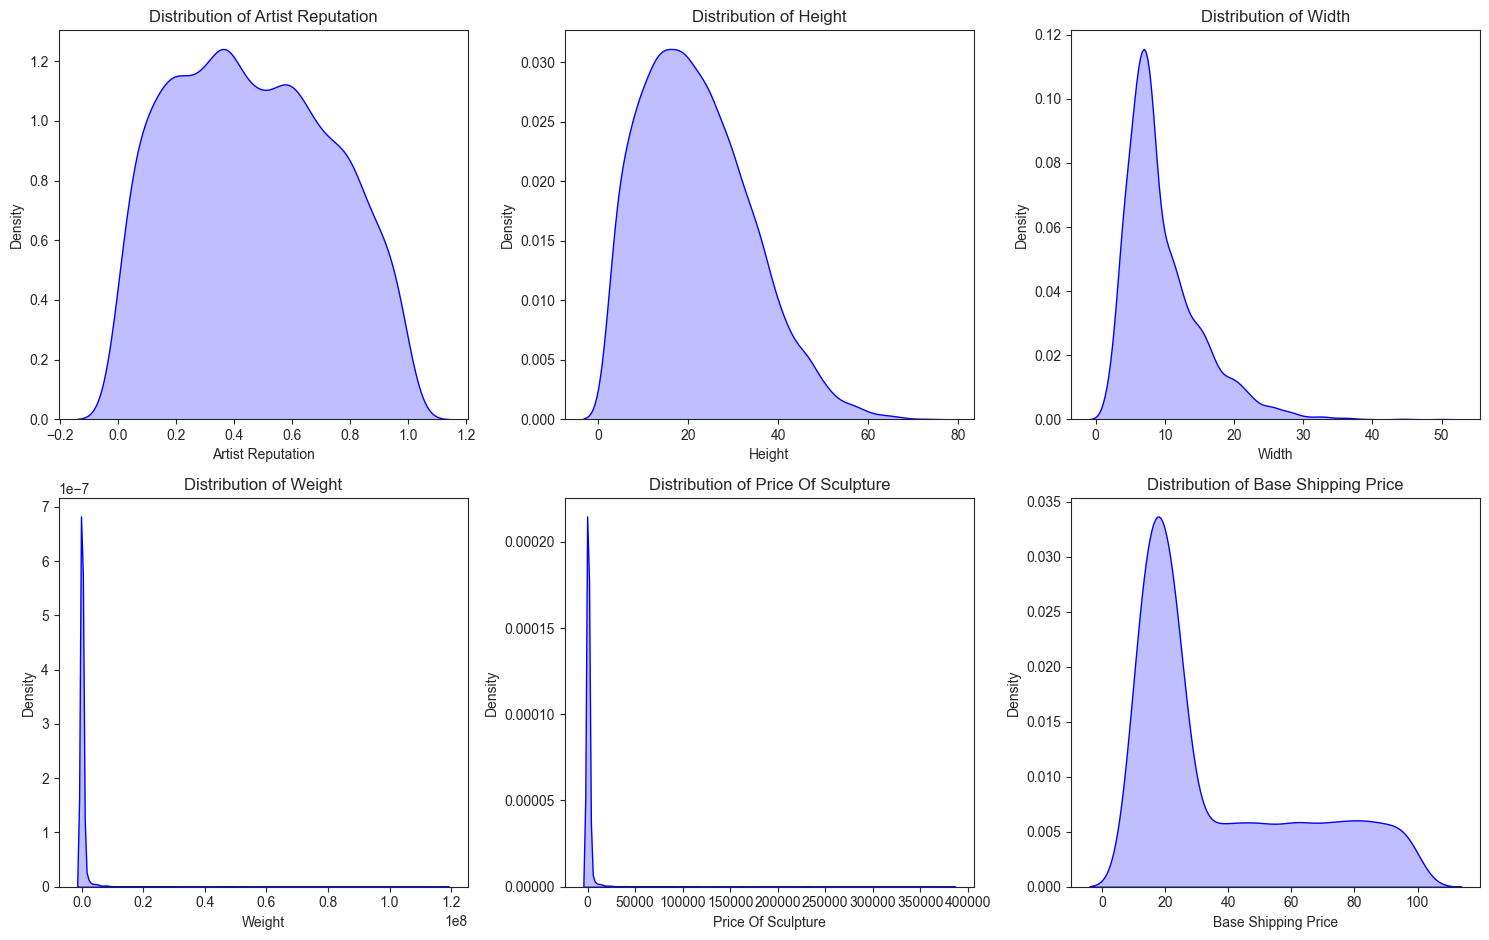

In [54]:
sns.set_style('ticks')
plt.suptitle('Data Distribution for Numerical Features', fontsize=20, fontweight='bold', alpha=0.8, y=1.)

num_rows = int(np.ceil(len(numeric_features) / 3)) 
num_cols = 3

fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, 10))

axes = axes.flatten()

for i, feature in enumerate(numeric_features):
    sns.kdeplot(data=df[feature], shade=True, color='b', ax=axes[i])
    axes[i].set_title(f'Distribution of {feature}')
    axes[i].set_xlabel(feature)

for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])


plt.tight_layout(rect=[0, 0, 1, 0.95]) 
plt.show()


In [56]:
df[numeric_features].skew()

Artist Reputation       0.141363
Height                  0.594041
Width                   1.546702
Weight                 21.556174
Price Of Sculpture     22.206823
Base Shipping Price     0.918102
dtype: float64

In [60]:
skewness_values = df[numeric_features].skew()

print("\nSkewness of Numerical Features:")
print("---------------------------------")
for feature, skew in skewness_values.items():
    print(f"{feature:<20}: {skew:>8.3f}", end="  ")

    if -0.5 <= skew <= 0.5:
        print("(Approximately symmetric)")
    elif skew < -1:
        print("(Highly negatively skewed)")
    elif skew < -0.5:
        print("(Moderately negatively skewed)")
    elif skew > 1:
        print("(Highly positively skewed)")
    else:
        print("(Moderately positively skewed)")



Skewness of Numerical Features:
---------------------------------
Artist Reputation   :    0.141  (Approximately symmetric)
Height              :    0.594  (Moderately positively skewed)
Width               :    1.547  (Highly positively skewed)
Weight              :   21.556  (Highly positively skewed)
Price Of Sculpture  :   22.207  (Highly positively skewed)
Base Shipping Price :    0.918  (Moderately positively skewed)


**Insighs**

 - From EDA we have seen that the `Price Of Sculpture ` and `Weight` were extremely positively skewed may be because outliers

 - So we can handle this type of case using Power Transformer or log transformer
 
 - `Width` and `Base Shipping Price` too are slighty positively skewed but not severe as shown by skewness coefficient.


#### Checking the power transformer on outlier columns

In [61]:
outlier_feature = ['Price Of Sculpture', 'Weight']

In [62]:
from sklearn.preprocessing import PowerTransformer

In [63]:
pt = PowerTransformer(standardize=False)

outlier_data = df1[outlier_feature]

In [64]:
df1[outlier_feature] = pt.fit_transform(df1[outlier_feature])

In [65]:
df_outlier = pd.DataFrame(outlier_data, columns=outlier_feature)

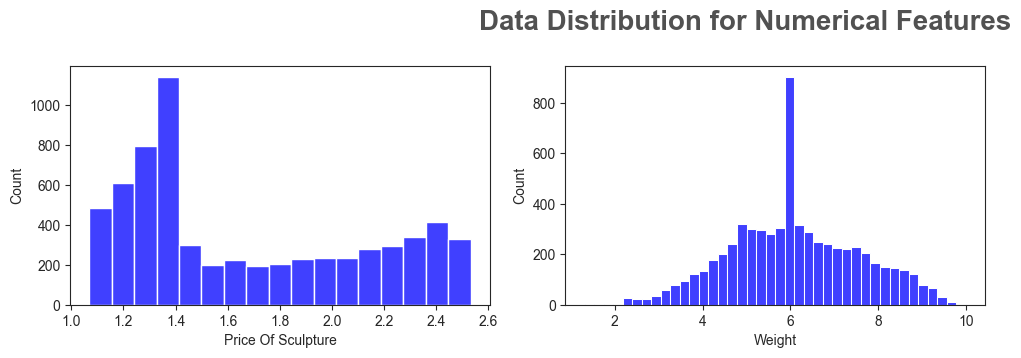

In [68]:
plt.figure(figsize=(15, 15))
plt.suptitle('Data Distribution for Numerical Features', fontsize=20, fontweight='bold', alpha=0.8, y=1.)

for i in range(0, len(outlier_feature)):
    plt.subplot(5, 3, i+1)
    sns.histplot(x=df1[outlier_feature[i]], color='b')
    plt.xlabel(outlier_feature[i])
    plt.tight_layout()


<Figure size 640x480 with 0 Axes>

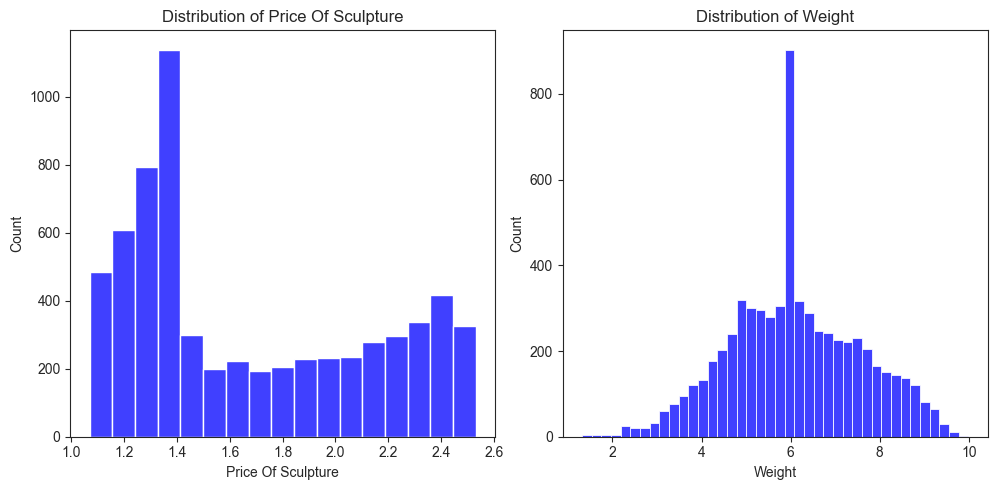

In [78]:
sns.set_style('ticks')
num_rows = int(np.ceil(len(outlier_feature) / 3)) 

plt.suptitle('Data Distribution for Outlier Features', fontsize=20, fontweight='bold', alpha=0.8, y=1.)

fig, axes = plt.subplots(nrows=num_rows, ncols=3, figsize=(15, 5 * num_rows))

axes = axes.flatten()

for i, feature in enumerate(outlier_feature):
    sns.histplot(data=df1, x=feature, color='b', ax=axes[i])
    axes[i].set_title(f'Distribution of {feature}')
    axes[i].set_xlabel(feature)

for j in range(i + 1, len(axes)): # Remove any unused subplots
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


In [75]:
outlier_data.skew()

Price Of Sculpture    22.206823
Weight                22.574798
dtype: float64

In [74]:
df1[outlier_feature].skew()

Price Of Sculpture    0.478648
Weight                0.027309
dtype: float64

**Insights**
 - Power transformer does a better job at overcoming skewness and handling outliers

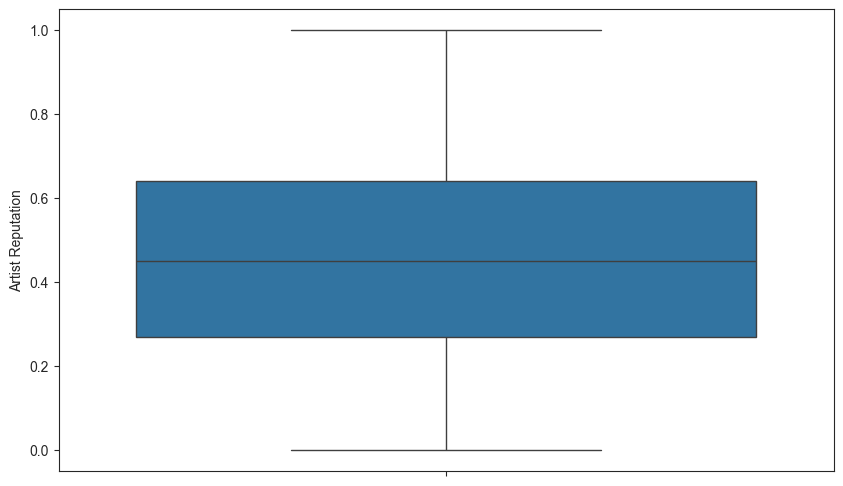

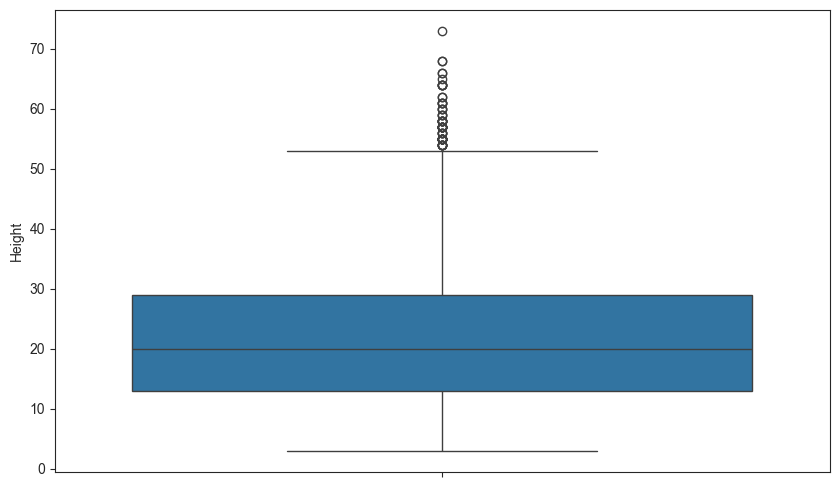

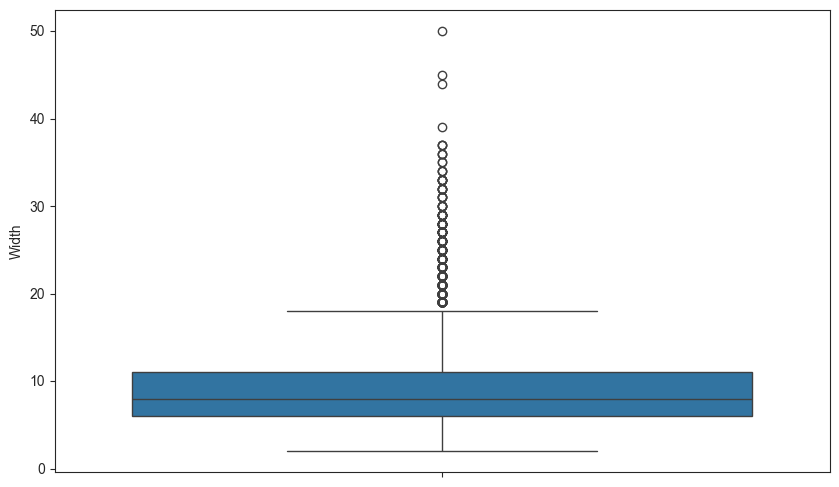

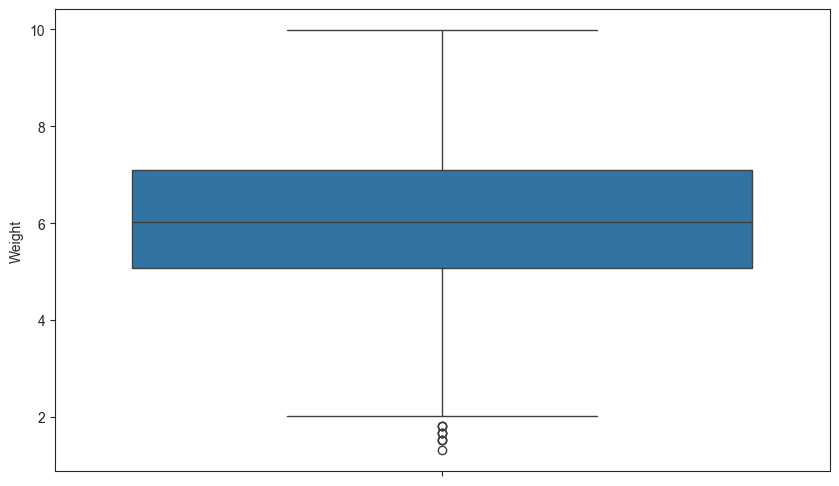

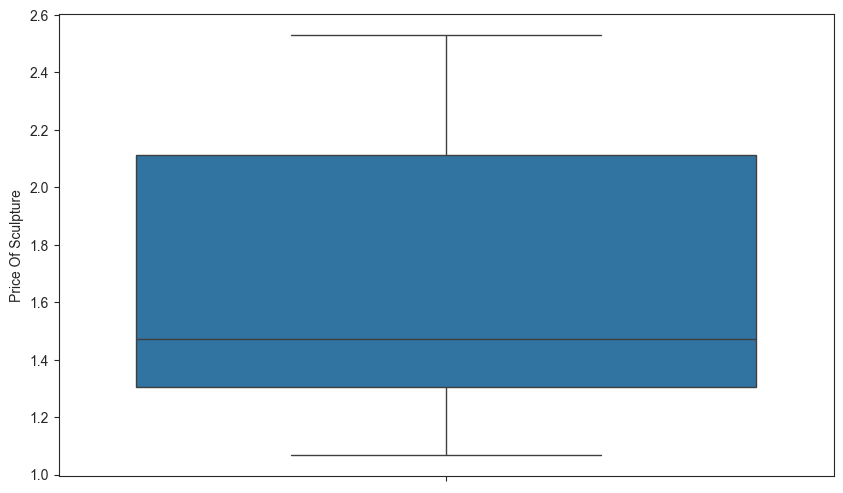

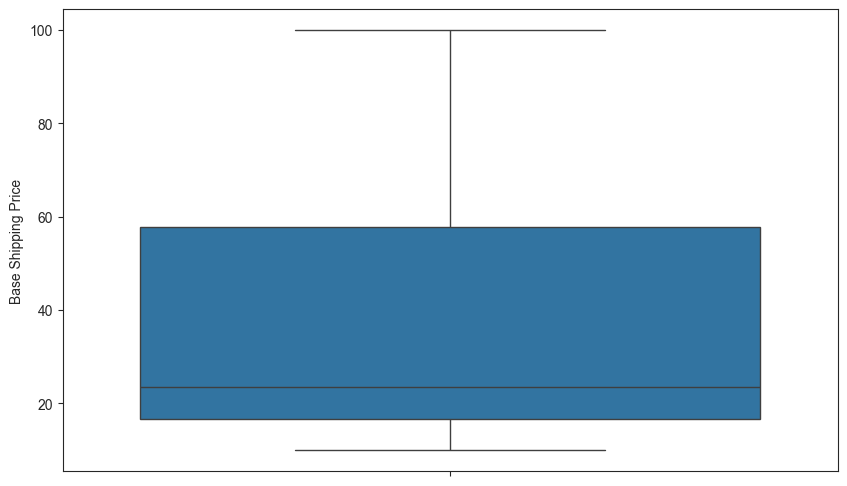

In [79]:
for i in numeric_features:
    plt.figure(figsize=(10,6))
    sns.set_style('ticks')
    ax = sns.boxplot(df1[i])

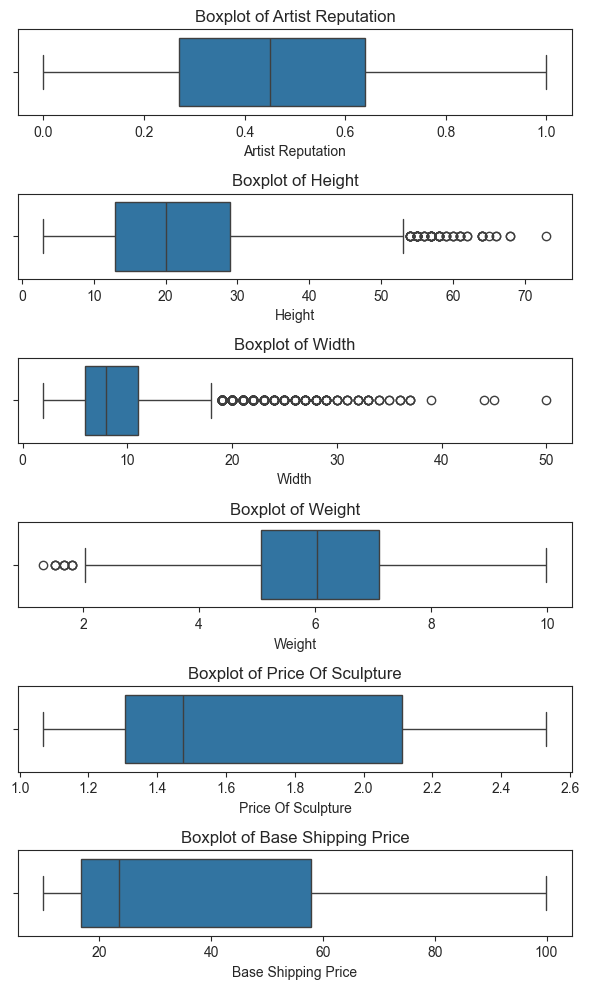

In [81]:
sns.set_style('ticks')

fig, axes = plt.subplots(nrows=len(numeric_features), figsize=(6, 10))

axes = axes.flatten()

for i, feature in enumerate(numeric_features):
    sns.boxplot(data=df1, x=feature, ax=axes[i])  
    axes[i].set_title(f'Boxplot of {feature}')


plt.tight_layout()
plt.show()


#### Removing outliers from Target Column
* Because most model would perform better on noiseless data, as Outlier might skew the findings of your model in one direction

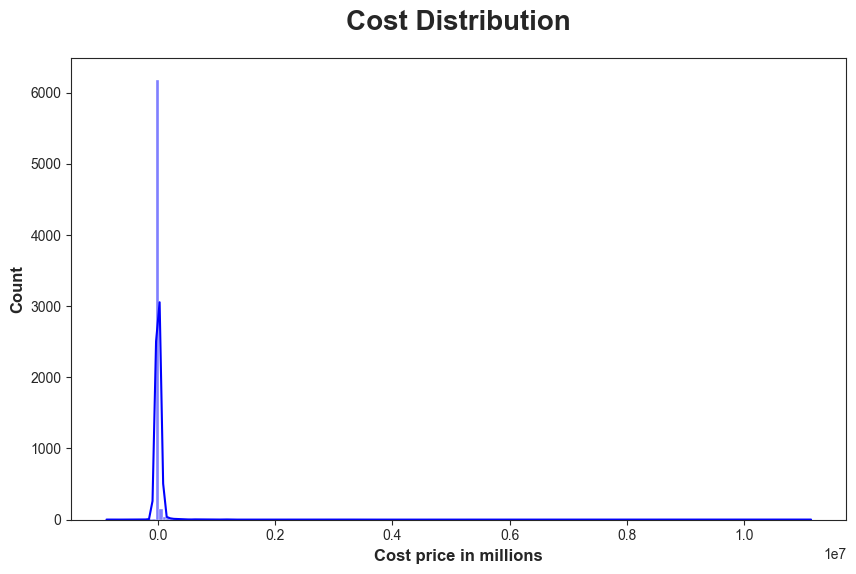

In [87]:
plt.subplots(figsize=(10,6))
sns.histplot(df['Cost'], bins=200, kde=True, color = 'b')
plt.title("Cost Distribution", weight="bold",fontsize=20, pad=20)
plt.ylabel("Count", weight="bold", fontsize=12)
plt.xlabel("Cost price in millions", weight="bold", fontsize=12)
plt.show()

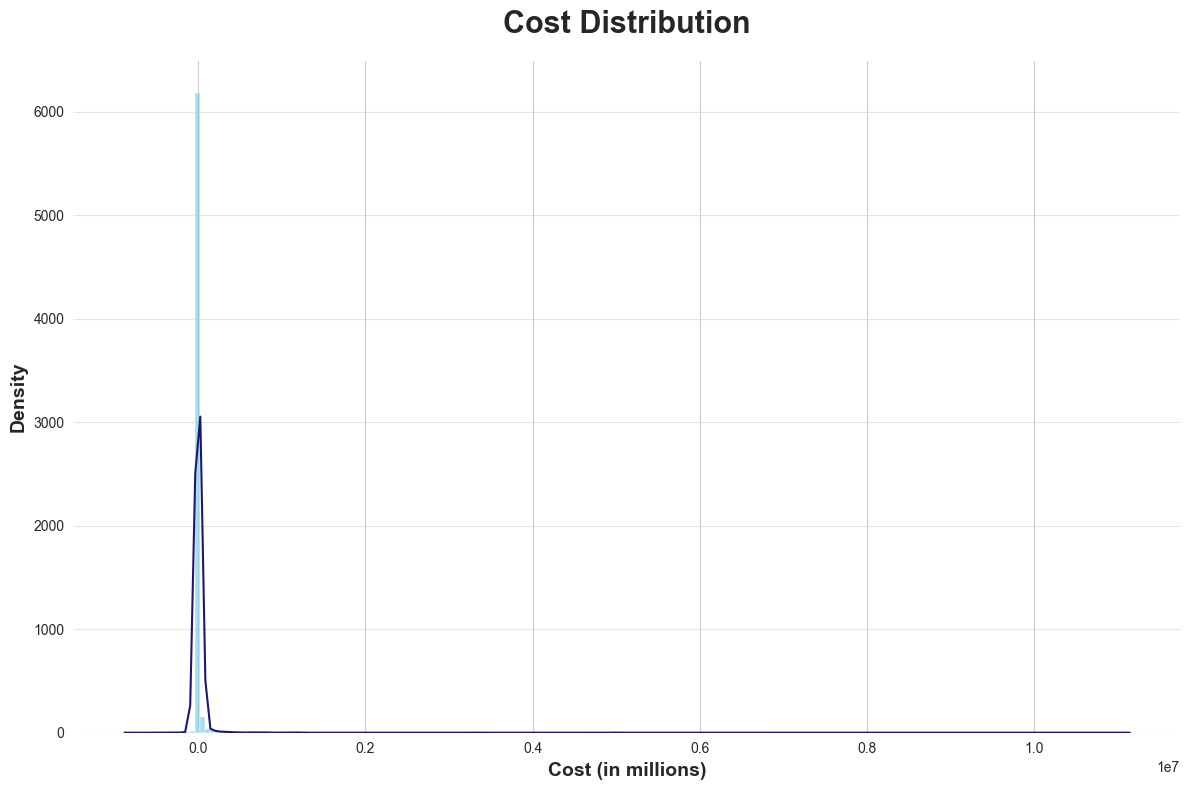

In [98]:

plt.figure(figsize=(12, 8)) 
sns.set_style("whitegrid")  
sns.set_palette("husl", 8) 

ax = sns.histplot(df['Cost'], bins=200, kde=True, color='skyblue', alpha=0.7)  
ax.lines[0].set_color('midnightblue')  # Customize KDE line color

plt.title("Cost Distribution", weight="bold", fontsize=22, pad=20)  
plt.ylabel("Density", weight="bold", fontsize=14) 
plt.xlabel("Cost (in millions)", weight="bold", fontsize=14)


ax.grid(axis='y', alpha=0.5)  
sns.despine(left=True, bottom=True)  

plt.tight_layout()
plt.show()


Need to apply transformation to target column to make it normally distributed. we use 1p to avoid `inf` values arise dued to `0` in the target column

In [99]:
df1['Cost'] = np.log1p(df1['Cost'])

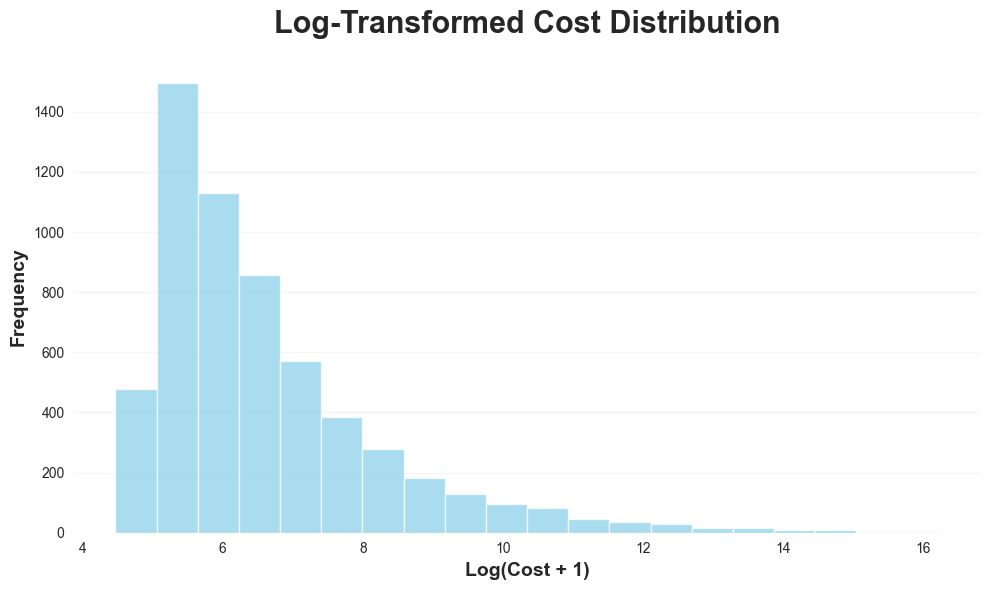

In [107]:
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

plt.hist(df1['Cost'], bins=20, color='skyblue', alpha=0.7)


plt.title("Log-Transformed Cost Distribution", weight="bold", fontsize=22, pad=20)
plt.ylabel("Frequency", weight="bold", fontsize=14)  
plt.xlabel("Log(Cost + 1)", weight="bold", fontsize=14)

plt.grid(axis='y', alpha=0.2)
plt.grid(axis='x', alpha=0)
sns.despine(left=True, bottom=True)

plt.tight_layout()
plt.show()


Data looks good after the log transformation but not Normally distributed.

#### Feature Creation for Date Columns

In [108]:
# Convert object datatype to datetime
df['Scheduled Date'] = pd.to_datetime(df['Scheduled Date'])
df['Delivery Date'] = pd.to_datetime(df['Delivery Date'])

In [109]:
df['Month'] = pd.to_datetime(df['Scheduled Date']).dt.month
df['Year'] = pd.to_datetime(df['Scheduled Date']).dt.year

numeric_features.append('Month')
numeric_features.append('Year')

#### Drop Unneccessary column

Drop `Customer Id`, `Artist Name` and `Customer Location` columns having huge number of unique values.

`Scheduled Date` and `Delivery Date` can be dropped since the required features are extracted form it

In [110]:
to_drop_columns = ['Customer Id', 'Artist Name', 'Customer Location', 'Scheduled Date', 'Delivery Date']

In [111]:
df.drop(columns=to_drop_columns, inplace=True)

### Model Building

In [121]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PowerTransformer, LabelEncoder, OrdinalEncoder, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

from sklearn.linear_model import LinearRegression, Ridge,Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor
from sklearn.svm import SVR
from catboost import CatBoostRegressor
from xgboost import XGBRegressor

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import RandomizedSearchCV, train_test_split, GridSearchCV



### Split X and y

In [113]:
X = df.drop(columns = ['Cost'], axis=1)
y = np.abs(df['Cost'])

In [114]:
y = np.log1p(y)

## Train Test Split

* The train-test split procedure is used to estimate the performance of machine learning algorithms when they are used to make predictions on data not used to train the model.

* It is a fast and easy procedure to perform, the results of which allow you to compare the performance of machine learning algorithms.

In [115]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Feature Encoding and Scaling

**Selecting Numerical and categorical features for feature scaling**

In [116]:
numeric_features = [x for x in numeric_features if x not in outlier_feature]
categorical_features = [x for x in non_numeric_features if x not in to_drop_columns]

(numeric_features), (categorical_features), (outlier_feature)

(['Artist Reputation',
  'Height',
  'Width',
  'Base Shipping Price',
  'Month',
  'Year'],
 ['Material',
  'International',
  'Express Shipment',
  'Installation Included',
  'Transport',
  'Fragile',
  'Customer Information',
  'Remote Location'],
 ['Price Of Sculpture', 'Weight'])

In [117]:
numeric_features_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', RobustScaler())
])

categorical_features_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('one_hot_encoder', OneHotEncoder()),
]
)

outliers_features_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('transformer', PowerTransformer(standardize=True))
])

preprocessor = ColumnTransformer(
    [
        ("Numeric Pipeline",numeric_features_pipeline, numeric_features),
        ("Categorical Features Pipeline",categorical_features_pipeline, categorical_features),
        ("Outliers Features Pipeline", outliers_features_pipeline, outlier_feature)
]
)

In [118]:
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

## Model Selection
* **Here should understand the Various Classification models with default values from these models we can choose top 4 with Highest Accuracy score and proceed with HyperParameter Tuning**

In [120]:
def evaluate_reg(true, predicted):

    mae = mean_absolute_error(true, predicted)
    mse = mean_squared_error(true, predicted)
    rmse = np.sqrt(mse) 
    r2_square = r2_score(true, predicted)

    return mae, rmse, r2_square


In [131]:
from time import time 

def evaluate_models(X_train, X_test, y_train, y_test, models):
    """
    Evaluates multiple regression models on training and testing data.

    Args:
        X_train: Training features.
        X_test: Testing features.
        y_train: Training target values.
        y_test: Testing target values.
        models: Dictionary of models to evaluate (keys are names, values are model instances).

    Returns:
        pandas.DataFrame: Sorted report of model performance metrics.
    """

    results = []
    for model_name, model in models.items():
        start_time = time()  
        model.fit(X_train, y_train)
        fit_time = time() - start_time

        print(f"Finished training '{model_name}' in {fit_time:.2f} seconds.")

        y_pred_train = model.predict(X_train)
        y_pred_test = model.predict(X_test)

        metrics = {
            'Model Name': model_name,
            'Train MAE': mean_absolute_error(y_train, y_pred_train),
            'Test MAE': mean_absolute_error(y_test, y_pred_test),
            'Train RMSE': mean_squared_error(y_train, y_pred_train, squared=False),
            'Test RMSE': mean_squared_error(y_test, y_pred_test, squared=False),
            'Train R^2': r2_score(y_train, y_pred_train),
            'Test R^2': r2_score(y_test, y_pred_test),
            'Fit Time (s)': fit_time
        }
        
        results.append(metrics)

    report = pd.DataFrame(results).sort_values(by=["Test R^2"], ascending=False)
    return report


In [132]:
models = {
    "Linear Regression": LinearRegression(),
    "K-Neighbors Regressor": KNeighborsRegressor(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest Regressor": RandomForestRegressor(),
    "XGBRegressor": XGBRegressor(), 
    "CatBoosting Regressor": CatBoostRegressor(verbose=False, max_depth=5),
    "AdaBoost Regressor": AdaBoostRegressor(), 
    "SVR": SVR()
}

In [133]:
base_report = evaluate_models(X_train, X_test, y_train, y_test, models)

Finished training 'Linear Regression' in 0.01 seconds.
Finished training 'K-Neighbors Regressor' in 0.00 seconds.
Finished training 'Decision Tree' in 0.15 seconds.
Finished training 'Random Forest Regressor' in 10.97 seconds.
Finished training 'XGBRegressor' in 0.11 seconds.
Finished training 'CatBoosting Regressor' in 1.76 seconds.
Finished training 'AdaBoost Regressor' in 0.57 seconds.
Finished training 'SVR' in 0.92 seconds.


In [134]:
base_report

,Model Name,Train MAE,Test MAE,Train RMSE,Test RMSE,Train R^2,Test R^2,Fit Time (s)
5,CatBoosting Regressor,0.117823,0.162845,0.183053,0.277112,0.987707,0.971792,1.759073
4,XGBRegressor,0.065831,0.184603,0.099689,0.314760,0.996354,0.963607,0.105544
3,Random Forest Regressor,0.078916,0.201837,0.122364,0.347167,0.994507,0.955727,10.968956
7,SVR,0.229666,0.258535,0.469386,0.486570,0.919169,0.913033,0.916384
2,Decision Tree,0.000000,0.326775,0.000000,0.524631,1.000000,0.898896,0.146432
6,AdaBoost Regressor,0.496176,0.506663,0.592222,0.625672,0.871328,0.856202,0.568487
1,K-Neighbors Regressor,0.361359,0.426334,0.567540,0.658831,0.881829,0.840555,0.001008
0,Linear Regression,0.498858,0.484655,0.736134,0.696006,0.801194,0.822055,0.010940


#### Hyperparameter Tuning

In [135]:
#Initialize few parameter for Hyperparamter tuning
rf_params = {"max_depth": [5, 8, 15, None, 10],
             "max_features": [5, 7, "auto", 8],
             "min_samples_split": [2, 8, 15, 20],
             "n_estimators": [100, 200, 500, 1000]}

xgboost_params = {"learning_rate": [0.1, 0.01],
                  "max_depth": [5, 8, 12, 20, 30],
                  "n_estimators": [100, 200, 300],
                  "colsample_bytree": [0.5, 0.8, 1, 0.3, 0.4]}

cat_params = {"learning_rate": [0.1, 0.01, 0.6, 0.5],
              "max_depth": [4, 5, 6, 8, 12]}

In [138]:
# Models list for Hyperparameter tuning
randomcv_models = [("RF", RandomForestRegressor(), rf_params),
                   ('XGBoost', XGBRegressor(), xgboost_params),
                   ('CatBoost', CatBoostRegressor(verbose=False), cat_params)
                   ]

In [136]:

def tune_hyperparameters(X_train, y_train, models, n_iter=100, cv=3, scoring='r2'):
    """
    Tunes hyperparameters for multiple models using RandomizedSearchCV.

    Args:
        X_train: Training features.
        y_train: Training target values.
        models: List of tuples (model_name, model_instance, param_distributions).
        n_iter: Number of random parameter combinations to try (default: 100).
        cv: Number of cross-validation folds (default: 3).
        scoring: Scoring metric to optimize (default: 'r2').

    Returns:
        dict: Dictionary mapping model names to best hyperparameters found.
    """

    best_params = {}
    for model_name, model, params in models:
        start_time = time()

        random_search = RandomizedSearchCV(
            estimator=model,
            param_distributions=params,
            n_iter=n_iter,
            cv=cv,
            scoring=scoring,
            verbose=2,
            n_jobs=-1  # Use all available CPU cores
        )
        
        random_search.fit(X_train, y_train)

        end_time = time()
        tuning_time = end_time - start_time
        print(f"Finished tuning {model_name} in {tuning_time:.2f} seconds.")

        best_params[model_name] = random_search.best_params_

    return best_params


In [139]:
best_hyperparams = tune_hyperparameters(X_train, y_train, randomcv_models)

for model_name, params in best_hyperparams.items():
    print(f"\nBest Hyperparameters for {model_name}:")
    for param, value in params.items():
        print(f"  {param}: {value}")


Fitting 3 folds for each of 100 candidates, totalling 300 fits
Finished tuning RF in 115.11 seconds.
Fitting 3 folds for each of 100 candidates, totalling 300 fits
Finished tuning XGBoost in 167.91 seconds.
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Finished tuning CatBoost in 734.33 seconds.

Best Hyperparameters for RF:
  n_estimators: 200
  min_samples_split: 2
  max_features: 8
  max_depth: 15

Best Hyperparameters for XGBoost:
  n_estimators: 300
  max_depth: 5
  learning_rate: 0.1
  colsample_bytree: 0.8

Best Hyperparameters for CatBoost:
  max_depth: 5
  learning_rate: 0.1


In [140]:
best_hyperparams

{'RF': {'n_estimators': 200,
  'min_samples_split': 2,
  'max_features': 8,
  'max_depth': 15},
 'XGBoost': {'n_estimators': 300,
  'max_depth': 5,
  'learning_rate': 0.1,
  'colsample_bytree': 0.8},
 'CatBoost': {'max_depth': 5, 'learning_rate': 0.1}}

In [141]:
# reInitialize models with best parameters
models = {
    "Random Forest Regressor": RandomForestRegressor(**best_hyperparams['RF'], n_jobs=-1),
    "XGBRegressor": XGBRegressor(**best_hyperparams['XGBoost'], n_jobs=-1), 
     "CatBoosting Regressor": CatBoostRegressor(**best_hyperparams['CatBoost'],verbose=False)
}

In [142]:
retrained_report = evaluate_models(X_train, X_test, y_train, y_test, models)

Finished training 'Random Forest Regressor' in 0.95 seconds.
Finished training 'XGBRegressor' in 0.31 seconds.
Finished training 'CatBoosting Regressor' in 1.79 seconds.


In [143]:
retrained_report

,Model Name,Train MAE,Test MAE,Train RMSE,Test RMSE,Train R^2,Test R^2,Fit Time (s)
2,CatBoosting Regressor,0.095636,0.160904,0.146101,0.278938,0.992169,0.971419,1.788287
1,XGBRegressor,0.090891,0.167898,0.142939,0.290312,0.992504,0.969041,0.313016
0,Random Forest Regressor,0.101341,0.229603,0.158080,0.368706,0.990832,0.950063,0.951880


### Best Model is CATBoost Regressor with $R^2$ Score of 0.97